In [15]:
%reload_ext autoreload
%autoreload 2

In [16]:
import math
import os
from sklearn.model_selection import train_test_split
import skimage.color as color
import numpy as np
np.set_printoptions(suppress=True)
from colors import ColorsCorpusReader
import colorsys


COLORS_SRC_FILENAME = os.path.join("data", "colors", "filteredCorpus.csv")


## Class to hold target color and text

In [17]:


def return_color(rgb_c) :
    lab = color.rgb2lab(np.asarray(rgb_c ))
    lab[0] = lab[0] /100.0 * 2.0 - 1.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    return lab

def represent_color_context(lab_cs):

    color_arr = np.asarray(lab_cs)
    max_arr   = np.argmax(color_arr, axis=0)   
    min_arr   = np.argmin(color_arr, axis=0) 
    color_arr[           : ,0] =  0.0
    color_arr[  max_arr[0] ,0] =  1.0
    color_arr[  min_arr[0] ,0] = -1.0

    return color_arr

def represent_color(lab,d_model):
    a    = np.pi
    size = d_model - 1 
    c = [ np.dot( lab , [1.0,np.cos(a*t/size),np.sin(a*t/size)] ) for t  in range(0,d_model,1) ]
    return np.array(c)

class ColorDataset() :

    def __init__(self,exs,d_model=128) :

        self.d_model = d_model
        # print(f"embedding dimension for a color :{self.d_model}")

        # turns a set of 3 rgb colors into 3 lab colors in context
        lab_colors      = lambda rgb_colors : represent_color_context( [ return_color(rgb_color) for rgb_color in rgb_colors] ) 

        # turns a set of 3 lab colors into 3 lab embeddings (each d_model dimensions)
        lab_embeddings  = lambda lab_colors : [ represent_color(lab_color,d_model) for lab_color in lab_colors ] 

        # retrieves hls colors and text list from examples
        all_hls_colors, self.texts  = zip(*[[ex.colors, ex.contents] for ex in exs])

        # converts hls colors to rgb colors
        all_rgb_colors            = [ [colorsys.hls_to_rgb(*color) for color in colors] for colors in all_hls_colors]

        # converts rgb colors to lab colors
        all_lab_colors            = [ lab_colors(rgb_colors) for rgb_colors in all_rgb_colors]

        # converts lab colors to lab embeddings
        all_lab_embeddings        = [ lab_embeddings(lab_colors) for lab_colors in all_lab_colors]

        # selects the target embedding correspnding to the target text
        self.target_embeddings           = [ lab_embeddings[2] for lab_embeddings in all_lab_embeddings] 

        # selects the target rgb color corresponding to the target text
        self.target_rgbs                 = [ rgb_colors[2]     for rgb_colors     in all_rgb_colors    ] 

        print(f"number of examples     :{len(self.texts)}" )


  

## Create datasets with embedding and text

- dataset.target_embeddings[0]
- dataset.target_rgbs[0]
- dataset.texts[0]

In [128]:

corpus   = ColorsCorpusReader(COLORS_SRC_FILENAME,word_count=None, normalize_colors=True)
examples = list(corpus.read())

EMB_SIZE           = 128 

far_examples  =  [ex for ex in examples if ex.condition == "far" ]
split_examples = [ex for ex in examples if ex.condition == "split" ]
close_examples = [ex for ex in examples if ex.condition == "close" ]


far_train  , far_test   = train_test_split(far_examples  ,train_size=.8)
close_train, close_test = train_test_split(close_examples,train_size=.8)
split_train, split_test = train_test_split(split_examples,train_size=.8)

far_train_ds, far_test_ds     = ColorDataset(far_train,d_model=EMB_SIZE) , ColorDataset(far_test,d_model=EMB_SIZE)
close_train_ds, close_test_ds = ColorDataset(split_train,d_model=EMB_SIZE),ColorDataset(close_test,d_model=EMB_SIZE) 
split_train_ds, split_test_ds = ColorDataset(close_train,d_model=EMB_SIZE), ColorDataset(split_test,d_model=EMB_SIZE) 


number of examples     :12625
number of examples     :3157
number of examples     :12554
number of examples     :3104
number of examples     :12415
number of examples     :3139


## Plot the first 10 color representations, along with the text that goes with it

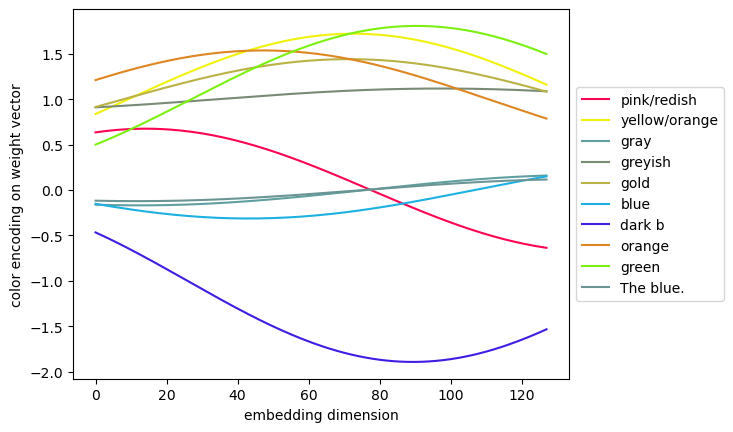

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(dataset, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(dataset.target_embeddings[i], color=dataset.target_rgbs[i], label=dataset.texts[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

sample = (  far_train_ds.target_rgbs[0] , far_train_ds.target_embeddings[0], far_train_ds.texts[0]  )

visualize(far_train_ds,range(0,10))


## Jameson Commentary

Preparation for experiments for this notebook:
 - I had to migrate in colors.py from the broader course notebook
 - I also loaded the data into this local repo in order to run the above code

Organization of this section:
 - run the experiment with the following configurations:
    - only context - [description] > [LM] > [embedding] > [encoder-decoder] ~ [target]
    - colors - [color] [color] [color] > [LM] > [embedding] > [encoder-decoder] ~ [target]
    - colors in context - [color] [color] [color] [description] > [LM] > [embedding] > [encoder-decoder]  ~ [target]


Notes about these experiments:
 - I changed from a random forest classifier to a encoder decoder architecture, as is standard for these kinds of experiments, and also more in line with our class approach
 - I used the gpt-2 model as the baseline model for all experiments

In [29]:
[e for e in dir(examples[ex]) if "__" not in e]

['_check_row_alignment',
 '_convert_hls_to_rgb',
 '_get_color_rep',
 '_get_reps_in_order',
 '_get_target_index',
 '_scale_color',
 'clickStatus',
 'color_data',
 'colors',
 'condition',
 'contents',
 'display',
 'gameid',
 'listener_context',
 'normalize_colors',
 'outcome',
 'parse_turns',
 'roundNum',
 'speaker_context']

In [48]:
far_examples[0].color_data

[{'type': 'click',
  'Status': 'target',
  'rep': [0.6916666666666667, 0.5, 0.25],
  'speaker': 1,
  'listener': 2},
 {'type': 'alt1',
  'Status': 'distr2',
  'rep': [0.15, 0.5, 0.53],
  'speaker': 3,
  'listener': 3},
 {'type': 'alt2',
  'Status': 'distr1',
  'rep': [0.35833333333333334, 0.5, 0.66],
  'speaker': 2,
  'listener': 1}]

In [ ]:
far_train_ds.target_rgbs[0] , far_train_ds.texts[0]

((0.985, 0.015000000000000013, 0.3221666666666662), 'pink/redish')

In [36]:
ex = 4
[examples[ex].contents, \
    examples[ex].speaker_context, \
    # examples[ex].color_data, \
    examples[ex].clickStatus, \
    examples[ex].outcome]

['Mint green.',
 [[0.43333333333333335, 0.5, 0.84],
  [0.6638888888888889, 0.5, 0.87],
  [0.15833333333333333, 0.5, 0.64]],
 'target',
 True]

Mint green.


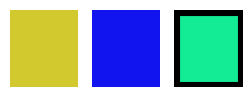

In [37]:
examples[ex].display()

In [70]:
examples[0]._get_target_index('listener')

1

In [74]:
examples[0].color_data

[{'type': 'click',
  'Status': 'distr2',
  'rep': [0.6888888888888889, 0.5, 0.92],
  'speaker': 3,
  'listener': 1},
 {'type': 'alt1',
  'Status': 'target',
  'rep': [0.6277777777777778, 0.5, 0.81],
  'speaker': 1,
  'listener': 2},
 {'type': 'alt2',
  'Status': 'distr1',
  'rep': [0.7861111111111111, 0.5, 0.87],
  'speaker': 2,
  'listener': 3}]

In [157]:
from transformers import pipeline

# the feature extraction pipeline can be used to extract generic, publicly available HF models

# pipeline = pipeline('feature-extraction', model='xlnet-base-cased')
pipeline = pipeline('feature-extraction', model='gpt2')

# tokenization may lead to different output structures depending upon how the model ingests the 
data = pipeline(examples[ex].contents)

In [49]:
len(examples[::10])

4700

In [163]:
import pandas as pd

examples_vals = [(x.colors, x.contents, np.array(np.mean(pipeline(x.contents), axis=1)[0]), len(np.array(np.mean(pipeline(x.contents), axis=1)[0])), x._get_target_index('listener'), x._get_target_index('speaker')) for x in far_examples]
ex_pd = pd.DataFrame(examples_vals, columns=['colors', 'contents', 'features', 'num_features', 'listener', 'speaker'])
ex_pd.head()

,colors,contents,features,num_features,listener,speaker
0,"[[0.35833333333333334, 0.5, 0.66], [0.15, 0.5,...",purple,"[0.03030075877904892, -0.07557344436645508, -0...",768,1,0
1,"[[0.15833333333333333, 0.5, 0.64], [0.66388888...",Mint green.,"[0.19400378316640854, -0.04312777891755104, -0...",768,2,0
2,"[[0.8, 0.5, 0.1], [0.16111111111111112, 0.5, 0...",Mud brown,"[0.4025663956999779, 0.06918821980555852, -0.3...",768,0,0
3,"[[0.45555555555555555, 0.5, 0.81], [0.25555555...",Grey,"[-0.08717162907123566, -0.03174428641796112, -...",768,2,2
4,"[[0.4777777777777778, 0.5, 0.65], [0.963888888...",Purple,"[0.19527915492653847, -0.18214910104870796, 0....",768,2,0


In [164]:
ex_pd.to_csv('data/far_ex_pd_gpt2.csv')

In [160]:
len(examples_vals)

158

In [167]:
def flatten(l):
    return [item for sublist in l for item in sublist]

X_train, X_test, y_train, y_test = train_test_split([flatten(x[0]) + x[1].tolist() for x in ex_pd[['colors', 'features']].values], ex_pd['speaker'], test_size=0.4, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split([x[1].tolist() for x in ex_pd[['colors', 'features']].values], ex_pd['speaker'], test_size=0.4, random_state=0)

def logistic_regression_classifier(inputs, target):
    from sklearn.linear_model import LogisticRegression
    import numpy as np
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(inputs, target)
    return clf

def random_forest_classifier(inputs, target):
    from sklearn.ensemble import RandomForestClassifier
    import numpy as np
    clf = RandomForestClassifier(n_estimators=len(inputs))
    clf.fit(inputs, target)
    return clf

import numpy as np
def predict(model, x):
    y_pred = model.predict(np.array(x))
    return y_pred

model = logistic_regression_classifier(X_train, y_train)


def pickle_model(model, filename):
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    f.close()

def load_model(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)
    f.close()

# pickle_model(model, 'models/far_model_bert.pkl')
pickle_model(model, 'models/far_model_gpt2.pkl')

# model = random_forest_classifier(X_train[::10], y_train[::10])
y_pred = predict(model, X_test)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('F1: %.3f' % f1)

/Users/jamesonlee/opt/anaconda3/envs/stanfordnlucourse/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision: 0.329
Recall: 0.327
F1: 0.322


In [169]:
print('GPT2 Model')

from sklearn.metrics import classification_report
results = classification_report(y_test, y_pred)
for row in results.split('\n'):
    print(row)

GPT2 Model
              precision    recall  f1-score   support

           0       0.33      0.37      0.35      2152
           1       0.32      0.39      0.35      2021
           2       0.34      0.22      0.27      2140

    accuracy                           0.33      6313
   macro avg       0.33      0.33      0.32      6313
weighted avg       0.33      0.33      0.32      6313



Purple


(['Purple',
  [[0.6361111111111111, 0.5, 0.31],
   [0.4777777777777778, 0.5, 0.65],
   [0.9638888888888889, 0.5, 0.52]],
  'target',
  True],
 None)

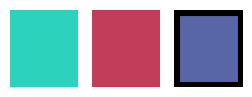

In [189]:
idx = 4
ex = far_examples[idx]

[ex.contents, \
    ex.speaker_context, \
    ex.clickStatus, \
    ex.outcome], ex.display()

In [190]:
ex_pd.iloc[idx]

colors          [[0.4777777777777778, 0.5, 0.65], [0.963888888...
contents                                                   Purple
features        [0.19527915492653847, -0.18214910104870796, 0....
num_features                                                  768
listener                                                        2
speaker                                                         0
Name: 4, dtype: object

In [191]:
model.predict([flatten(ex_pd['colors'].values[idx]) + ex_pd['features'].values[idx].tolist()])

array([1])